<a href="https://colab.research.google.com/github/iakioh/MusiCAN/blob/main/models/first_music_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# scaleGAN
**Description:** scalable GAN architecture with an equally scalable mock dataset.\
**Purpose:** find an efficient and stable architecture to generate images as large as pianorolls with.\
**Results:**

In [1]:
import pickle
import math
import numpy as np
import matplotlib.pyplot as plt
import torch

## Class and function definitions

### Data creation

In [2]:
class CentralDotImage :
    """
        creates mock data set out of a simple image copied multiple times

        Methods
        -------
        __init__(height, width, dataset_size = 100) : 
            creates all attributes
        show() : 
            plt.plots image

        Attributes
        ----------
        height : int
            of image, in pixels
        width : int
            of image, in pixels
        size : int
            number of pixels in image
        dataset_size : int
            number of images
        
        image : torch.Tensor
            out of 1s and 0s,
            size = (width, height)
        vector : torch.Tensor
            flattened image,
            size = (size)
        data : torch.Tensor
            images copied dataset_size times
            size = (dataset_size, size)
        dataset : torch.TensorDataset
    """

    def __init__ (self, height, width, dataset_size = 100) :
        # Input checks
        assert  type(height) == int 
        assert  height >= 1 
        assert  type(width) == int
        assert  width >= 1
        assert  type(dataset_size) == int
        assert  dataset_size >= 1

        self.height = height
        self.width  = width
        self.shape  = (height, width)
        self.size   = height * width
        self.dataset_size = dataset_size

        # Image creation
        self.image = torch.zeros(height, width)
        for i in range(height) :
            for j in range(width) :
                self.image[i, j] = \
                    i + 1 <= math.ceil(3/4 * height) and \
                    i + 1 > math.floor(1/4 * height) and \
                    j + 1 <= math.ceil(3/4 * width) and \
                    j + 1 > math.floor(1/4 * width)

        # Dataset creation
        self.vector  = self.image.flatten()
        self.data    = self.vector[None, :].expand(dataset_size, self.size)
        self.dataset = torch.utils.data.TensorDataset(self.data)

    def show (self) :
        plt.imshow(self.image)
        plt.show()

### Architecture

In [3]:
"""
    These two classes serves as torch layers to binarize the output of the Generator while keeping the layer still "backpropagatable" (via a hardtanh).
    This is not our own code. For source, see:
    https://www.hassanaskary.com/python/pytorch/deep%20learning/2020/09/19/intuitive-explanation-of-straight-through-estimators.html#:~:text=A%20straight%2Dthrough%20estimator%20is,function%20was%20an%20identity%20function.
"""

class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return torch.nn.functional.hardtanh(grad_output)

class StraightThroughEstimator(torch.nn.Module):
    def __init__(self):
        super(StraightThroughEstimator, self).__init__()

    def forward(self, x):
        x = STEFunction.apply(x)
        return x


In [4]:
class Network (torch.nn.Module) :
    """
        General neural network class for specialized networks.
        Create those by:
        ```
        myNet = Network(<int_input_length>, <int_output_length>, <str_name>)
        layer_list = [<torch.nn.Module1>, ...]
        myNet.create_model(layer_list)
        myNet.print_stats()
        ```
    """


    def __init__ (self, input_length, output_length, name) : 
        super().__init__()
        
        self.input_length  = self.I = input_length
        self.output_length = self.O = output_length
        self.name          = name
            

    def create_model (self, layer_list) :
        self.model = torch.nn.Sequential(*layer_list)


    def print_stats (self) :
        print(f"{self.name}:")
        print(f"    input length:  {self.input_length}")
        print(f"    output length: {self.output_length}")
        if hasattr(self, 'model') :
            print(f"    layers:        {len(self.model)}")
            print(f"    parameters:    {self.count_params()}")
        else :
            print(f"    Create the network architecture with .create_model(<layer_list>)")
        print("")


    def count_params (self) :
        """count number of trainable parameters"""

        return sum(p.numel() for p in self.parameters() if p.requires_grad)


    def forward (self, input, numpy_out = False) :
        """run network"""
        output = self.model(input)
        if numpy_out :
            output = self._numpify(output)

        return output
    
    
    def _numpify (self, tensor) :
        return tensor.detach().numpy()

In [5]:
class Generator (Network) :
    """
        GAN Generator class whose architecture is custom defined after initialization:
        ```
        myGen = Generator(<int_input_length>, <int_output_length>, <str_name>)
        layer_list = [<torch.nn.Module1>, ...]
        myGen.create_model(layer_list)
        myGen.print_stats()
        ```

        There are two forward() variants:
        * `forward(batchsize = 0, numpy_out = False)` with auto-generated normally distributed seeds.
        * `forward_custom(seed, numpy_out = False)` with custom seeds as input.
    """

    def forward (self, batch_size = 0, numpy_out = False) :
        """run network with a batch of normally distributed seeds"""
        assert  type(batch_size) == int
        assert  batch_size >= 0

        # Seed generation
        if batch_size == 0 :
            seed_size = (self.input_length,)
        else :
            seed_size = (batch_size, self.input_length)
        seed = torch.normal(0, 1, seed_size)
        
        # Running the network
        return super().forward(seed, numpy_out)

            
    def forward_custom (self, seed, numpy_out = False) :
        """run network with custom seed"""
        assert  type(seed) == torch.Tensor
        assert  seed.shape[-1] == self.I

        # Running the network
        return super().forward(seed, numpy_out = numpy_out)



In [6]:
class Discriminator (Network) :
    """
        GAN Discriminator class whose architecture is custom defined after initialization:
        ```
        myDis = Discriminator(<int_input_length>, <int_output_length>, <str_name>)
        layer_list = [<torch.nn.Module1>, ...]
        myDis.create_model(layer_list)
        myDis.print_stats()
        ```
    """

    def forward (self, input, prob_out = False, numpy_out = False) :
        """
            run network, optionally return probability (default logit) or numpy array (default torch)
        """
        assert  type(input) in [torch.Tensor, np.ndarray]
        assert  input.shape[-1] == self.I

        if type(input) == np.ndarray :
            input = torch.tensor(input)

        # Running the network
        
        output = super().forward(input)
        if prob_out :
            output = torch.sigmoid(output)
        if numpy_out :
            output = self._numpify(output)

        return output

### Training

In [7]:
def generator_goodness (generated_batch, real_batch) :
    """
    compare two batches of data by calculating the absolute mean difference
    """
    
    # averaged over batches 
    generated_mean = torch.mean(generated_batch)
    real_mean      = torch.mean(real_batch)

    # take differnece & absolut value, average over features lastly
    goodness_criteria = torch.mean(torch.abs(real_mean - generated_mean))

    return goodness_criteria.detach().numpy()

In [8]:
class GANTraining :
    def __init__ (self, generator, discriminator, dataset) :
        assert  type(generator) in [Network, Generator]
        assert  hasattr(generator, "model")
        assert  type(discriminator) in [Network, Discriminator]
        assert  hasattr(discriminator, "model")
        assert  type(dataset) == torch.utils.data.dataset.TensorDataset
        
        self.device = 'cuda'  if torch.cuda.is_available() else  'cpu'
        self.training_filepath = "../execution/trained_models/"

        # Model, data and optimizer
        self.gen     = generator.to(self.device)
        self.dis     = discriminator.to(self.device)
        self.dataset = dataset.to(self.device)
        self.optimizer_gen = torch.optim.Adam(self.gen.parameters(), 
                                              lr = 0.001,
                                              betas = (0.5, 0.9))
        self.optimizer_dis = torch.optim.Adam(self.dis.parameters(), 
                                              lr = 0.001,
                                              betas = (0.5, 0.9))
        # Note: ADAM parameters from GAN tutorial [1].
        

    def set_params (self, rounds, batch_size = 1, discriminator_rounds = 1, 
                    loss_function = "WGAN") :
        assert  type(rounds) == int
        assert  rounds >= 1
        assert  type(batch_size) == int
        assert  batch_size >= 1
        assert  type(discriminator_rounds) == int
        assert  discriminator_rounds >= 1
        assert  loss_function in ["GAN", "WGAN"]

        # Training parameters
        self.rounds     = rounds
        self.batch_size = batch_size
        self.dis_rounds = discriminator_rounds
        self.loss       = loss_function

        # Dataloader
        self.data_loader = torch.utils.data.DataLoader(self.dataset,
                                batch_size = self.batch_size, 
                                drop_last = True,
                                shuffle = True)
        
        # Logs
        self.log.losses       = np.zeros((5, self.rounds))
        self.log.probs        = np.zeros((2, self.rounds))
        self.log.gen_goodness = np.zeros((self.rounds,))
        self.log._dis_losses  = torch.zeros((4, self.dis_rounds))
        self.log._probs       = torch.zeros((2, self.dis_rounds))
        


    def train (self) :
        assert  hasattr(self, "data_loader")  # If test fails, you haven't run set_params()

        for round in range(self.rounds) :
            for dis_round in range(self.dis_rounds) :
                # Forward propagation
                batch_real = iter(self.data_loader)
                batch_gen  = self.gen.forward(batch_size = self.batch_size)
                dis_real = self.dis.forward(batch_real)
                dis_gen  = self.dis.forward(batch_gen)
                self.prob_real = torch.sigmoid(dis_real)
                self.prob_gen  = torch.sigmoid(dis_gen)

                # Calculating the Discriminator loss function
                if self.loss == "GAN" :
                    self.loss_real = - torch.mean(torch.log(self.prob_real))
                    self.loss_gen  = torch.mean(torch.log(
                                     1 - self.prob_gen))
                    self.loss_reg  = torch.tensor(0.)
                elif self.loss == "WGAN" :
                    var_gen   = torch.var(dis_gen)
                    var_real  = torch.var(dis_real)
                    self.loss_reg  = torch.where(var_gen > 1, 
                                                 (var_gen - 1)**2, 0) \
                                     + torch.where(var_real > 1, 
                                                   (var_real - 1)**2, 0)
                    self.loss_real = - torch.mean(dis_real)
                    self.loss_gen  = torch.mean(dis_gen)

                self.loss_dis = self.loss_real + self.loss_gen + self.loss_reg
                self._log_all(round, k = dis_round)
                
                # Discriminator update
                self.optimizer_dis.zero_grad()
                loss_dis.backward(retain_graph = True)
                self.optimizer_dis.step()

            # Calculating the Generator loss function
            batch_gen = self.gen.forward(batch_size = self.batch_size)
            dis_new   = self.dis.forward(batch_gen)
            
            if self.loss_function == "GAN" :
                prob_new = torch.sigmoid(dis_new)
                self.loss_gen = -torch.mean(torch.log(prob_new)) 
            elif self.loss_function == "WGAN" :
                self.loss_gen = -torch.mean(dis_new)
            self._log_all(round)
            
            # Generator update
            self.optimizer_gen.zero_grad()
            self.loss_gen.backward()
            self.optimizer_gen.step()


    def _log_all (round, k = -1) :
        if k >= 0 : # before each Discriminator update
            self.log._dis_losses[0, k] = self.loss_dis
            self.log._dis_losses[1, k] = self.loss_real
            self.log._dis_losses[2, k] = self.loss_gen
            self.log._dis_losses[3, k] = self.loss_reg
            self.log._probs[0, k] = self.prob_real.mean()
            self.log._probs[1, k] = self.prob_gen
        
        if k == -1 : # before each Generator update
            dis_losses = self.log._dis_losses.detach().numpy()
            probs      = self.log._probs.detach().numpy()
            self.log.losses[0:4, round] = dis_losses.mean(axis = 1)
            self.log.losses[5, round]   = self.loss.gen.detach().numpy()
            self.log.probs[:, round]    = probs.mean(axis = 1)

            batch_real = iter(self.data_loader)
            batch_gen  = self.gen.forward(batch_size = self.batch_size)
            goodness   = generator_goodness(batch_gen, batch_real)
            self.log.gen_goodness[round] = goodness



    def save (self, name) :
        file_name = self.training_filepath + name + ".obj"
        file      = open(file_name, "wb")
        pickle.dump(self, file)
        print(f"Saved training under '{file_name}'")


    def load (name) :
        file_name = self.training_filepath + name + ".obj"
        file      = open(file_name, "rb")
        return pickle.load(file)


# Sources:
# [1] https://github.com/salu133445/ismir2019tutorial/blob/main/gan.ipynb

## Network training and evaluation

### Setup

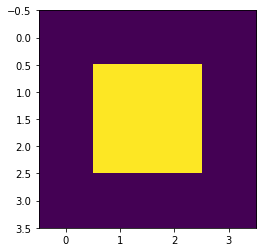

In [9]:
minimock = CentralDotImage(4, 4)
minimock.show()

In [10]:
miniGen = Generator(4, minimock.size, "miniGenerator")

miniGen.create_model([
    torch.nn.Linear(miniGen.I, miniGen.I),
    torch.nn.ReLU(),
    torch.nn.Linear(miniGen.I, miniGen.O),
    StraightThroughEstimator()
])

miniGen.print_stats()

miniGenerator:
    input length:  4
    output length: 16
    layers:        4
    parameters:    100



In [11]:
miniDis = Discriminator(minimock.size, 1, "miniDiscriminator")

miniDis.create_model([
    torch.nn.Linear(miniDis.I,4),
    torch.nn.ReLU(),
    torch.nn.Linear(4, miniDis.O)
])

miniDis.print_stats()

miniDiscriminator:
    input length:  16
    output length: 1
    layers:        3
    parameters:    73



Prob. that image is real: 50%


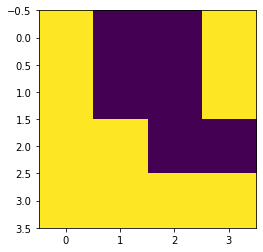

In [12]:
gen_flat = miniGen.forward(numpy_out = True)
prob     = miniDis.forward(gen_flat, prob_out = True, numpy_out = True)[0]

print(f"Prob. that image is real: {prob*100:.0f}%")
gen_img = gen_flat.reshape(*minimock.shape)
plt.imshow(gen_img);

### Tests